Balanced class counts:
 label
Naeimi     204
Barbari     90
Goat        90
Harri       90
Najdi       90
Roman       90
Sawakni     90
Name: count, dtype: int64
Found 744 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.
Epoch 1/6


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.1624 - loss: 2.4790 - val_accuracy: 0.1022 - val_loss: 1.9881
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.2025 - loss: 2.0503 - val_accuracy: 0.4088 - val_loss: 1.8533
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.2084 - loss: 1.9868 - val_accuracy: 0.3723 - val_loss: 1.8492
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.2667 - loss: 1.8984 - val_accuracy: 0.3723 - val_loss: 1.8982
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.2567 - loss: 1.9103 - val_accuracy: 0.3723 - val_loss: 1.9141
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.1967 - loss: 1.6163 - val_accuracy: 0.3723 - val_loss: 1.3841 - learning_rate: 2.0000e-05
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.2202 - loss: 1.5108 - val_accuracy: 0.3723 - val_loss: 1.3899 - learning_rate: 2.0000e-05
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2386 - loss:

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


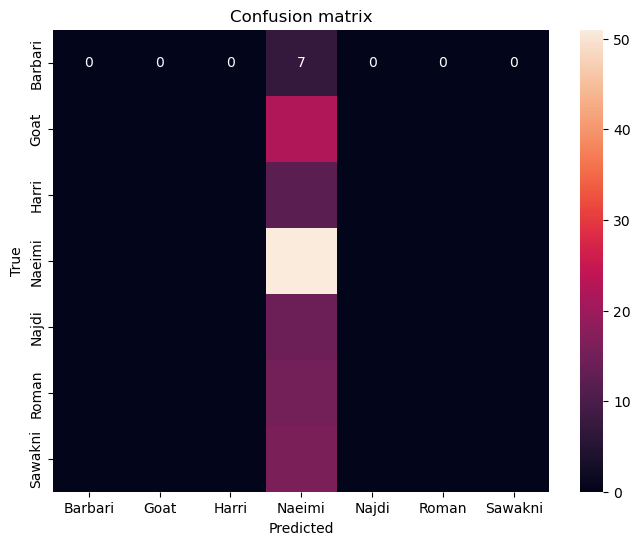

In [1]:
# ---------------- 0. Imports & paths ----------------
import pandas as pd, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

# ---------------- 1. dataframe ----------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
labels = list(df["label"].astype("category").cat.categories)
NUM_CLASSES = len(labels)

train_df, val_df = train_test_split(
    df, test_size=0.20, stratify=df["label_idx"], random_state=42
)

# --------- 2. uniform oversample  -------------------
# ► EVERY breed gets at least 90 samples ◄
TARGET = 90
oversampled = []
for lbl, grp in train_df.groupby("label"):
    if len(grp) < TARGET:
        grp = resample(grp, replace=True, n_samples=TARGET, random_state=42)
    oversampled.append(grp)

train_df_bal = pd.concat(oversampled).reset_index(drop=True)
print("Balanced class counts:\n", train_df_bal["label"].value_counts())

# ---------------- 3. generators ---------------------
train_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20, width_shift_range=0.12, height_shift_range=0.12,
    zoom_range=0.15, horizontal_flip=True
)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_dataframe(
    train_df_bal, x_col="file_path", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# ------------- 4. focal loss with softer α ---------- 
# order must follow `labels`
alpha_vec = tf.constant([1.6, 0.9, 1.2, 0.8, 1.1, 1.3, 1.0], dtype=tf.float32)
LABEL_SMOOTH = 0.05
def focal_loss_pc(gamma=2.):
    def _loss(y_true, y_pred):
        y_true = y_true * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / NUM_CLASSES
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = tf.pow(1 - y_pred, gamma) * ce * alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

# ---------------- 5. model --------------------------
base = ResNet50(include_top=False, weights="imagenet",
                input_tensor=Input(shape=(224, 224, 3)))

base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(base.input, out)

model.compile(Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

# ---------------- 6. train head ---------------------
model.fit(
    train_gen, validation_data=val_gen,
    epochs=6,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

# ---- unfreeze last 50 & switch loss / LR -----------
for layer in base.layers[:-50]:
    layer.trainable = False
for layer in base.layers[-50:]:
    layer.trainable = True

model.compile(
    Adam(2e-5),              # fine-tune learning-rate
    loss=focal_loss_pc(),
    metrics=["accuracy"]
)

model.fit(
    train_gen, validation_data=val_gen,
    epochs=30,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
])

# ---------------- 7. evaluation ---------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(probs, 1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

Balanced class counts:
 label
Naeimi     204
Barbari    200
Roman      120
Goat        85
Sawakni     64
Najdi       57
Harri       50
Name: count, dtype: int64
Found 780 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.
Epoch 1/6


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.1733 - loss: 2.3871 - val_accuracy: 0.3723 - val_loss: 1.8433
Epoch 2/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.2152 - loss: 1.9355 - val_accuracy: 0.2701 - val_loss: 1.8967
Epoch 3/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.2764 - loss: 1.8607 - val_accuracy: 0.3723 - val_loss: 1.8705
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.2113 - loss: 1.4370 - val_accuracy: 0.3723 - val_loss: 1.2914 - learning_rate: 5.0000e-05
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.2902 - loss: 1.2614 - val_accuracy: 0.3723 - val_loss: 1.2667 - learning_rate: 5.0000e-05
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.2978 - loss: 1.2775 - val_accuracy: 0.3723 - val_loss: 1.2289 - learning_rate: 5.0000e-05
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.3271 - loss: 1.1685 - val_accuracy: 0.3577 - val_loss: 1.1942 - learning_rate: 5.0000e-05
Epoch 5/30
25/2

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


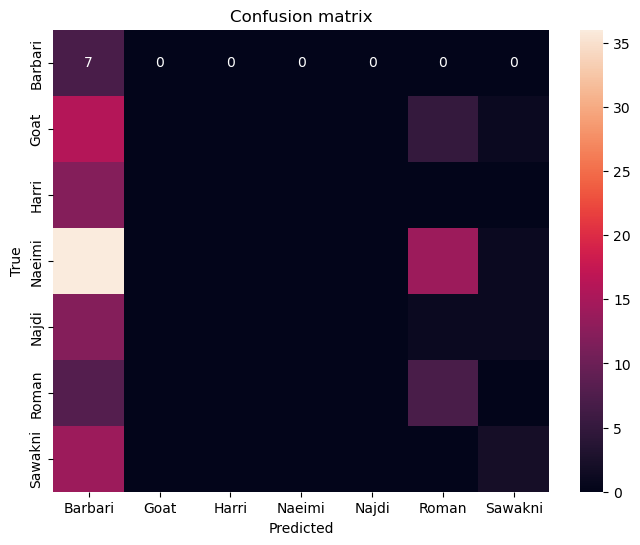

In [2]:
# ---------------- 0. Imports & paths ----------------
import pandas as pd, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

# ---------------- 1. dataframe ----------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
labels = list(df["label"].astype("category").cat.categories)
NUM_CLASSES = len(labels)

train_df, val_df = train_test_split(
    df, test_size=0.20, stratify=df["label_idx"], random_state=42
)

# --------- 2. **targeted** oversample ----------------
TARGET = {"Barbari": 200, "Roman": 120}          # ↩ only these two get boosted
os_parts = []
for lbl, grp in train_df.groupby("label"):
    need = TARGET.get(lbl, len(grp))             # keep original count for others
    if len(grp) < need:
        grp = resample(grp, replace=True, n_samples=need, random_state=42)
    os_parts.append(grp)
train_df_bal = pd.concat(os_parts).reset_index(drop=True)
print("Balanced class counts:\n", train_df_bal["label"].value_counts())

# ---------------- 3. generators ---------------------
train_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.20, brightness_range=[0.8,1.2],
    horizontal_flip=True
)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_dataframe(
    train_df_bal, x_col="file_path", y_col="label",
    target_size=(224,224), batch_size=32,
    class_mode="categorical", shuffle=True
)
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    target_size=(224,224), batch_size=32,
    class_mode="categorical", shuffle=False
)

# ------------- 4. focal loss with tuned α ------------
alpha_vec = tf.constant([2.0, 0.6, 1.2, 0.3, 1.2, 1.5, 1.0], tf.float32)  # order = labels
LABEL_SMOOTH = 0.05
def focal_loss_pc(gamma=2.):
    def _loss(y_true, y_pred):
        # label-smoothing
        y_true = y_true * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / NUM_CLASSES
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = tf.pow(1 - y_pred, gamma) * ce * alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

# ---------------- 5. model --------------------------
base = ResNet50(include_top=False, weights="imagenet",
                input_tensor=Input(shape=(224,224,3)))

# ---- phase-1: train only the new head --------------
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(base.input, out)

model.compile(Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(
    train_gen, validation_data=val_gen,
    epochs=6,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

# ---- phase-2: unfreeze last 70 layers & fine-tune ---
for layer in base.layers[:-70]:
    layer.trainable = False
for layer in base.layers[-70:]:
    layer.trainable = True

model.compile(
    Adam(5e-5),                    # slightly higher LR than before
    loss=focal_loss_pc(),
    metrics=["accuracy"]
)

model.fit(
    train_gen, validation_data=val_gen,
    epochs=30,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
])

# ---------------- 6. evaluation ---------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(probs, 1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

Balanced counts:
 label
Naeimi     204
Barbari    200
Goat       200
Harri      200
Najdi      200
Roman      200
Sawakni    200
Name: count, dtype: int64
Found 1404 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.
Epoch 1/6


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.1471 - loss: 2.3113 - val_accuracy: 0.1606 - val_loss: 1.9548
Epoch 2/6
44/44 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.1492 - loss: 1.9999 - val_accuracy: 0.1095 - val_loss: 1.9417
Epoch 3/6
44/44 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.1485 - loss: 1.9631 - val_accuracy: 0.2482 - val_loss: 1.9443
Epoch 4/6
44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.1531 - loss: 1.9482 - val_accuracy: 0.1314 - val_loss: 1.9322
Epoch 5/6
44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.1397 - loss: 1.9626 - val_accuracy: 0.3650 - val_loss: 1.9266
Epoch 6/6
44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.1524 - loss: 1.9479 - val_accuracy: 0.1533 - val_loss: 1.9448
Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.1624 - loss: 1.5670 - val_accuracy: 0.1022 - val_loss: 1.4355 - learning_rate: 3.0000e-05
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step - accuracy: 0.1963 - loss: 1.3909 - val_accuracy

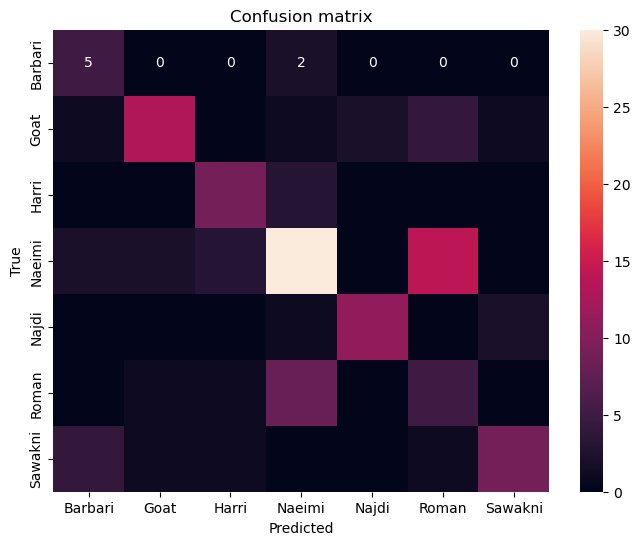

In [3]:
# ---------------- 0. Imports & paths ----------------
import pandas as pd, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

# ---------------- 1. dataframe ----------------------
df = pd.read_csv(CSV)
df["file_path"]  = ROOT + df["filename"]
df["label_idx"]  = df["label"].astype("category").cat.codes
labels           = list(df["label"].astype("category").cat.categories)
NUM_CLASSES      = len(labels)

train_df, val_df = train_test_split(
    df, test_size=0.20, stratify=df["label_idx"], random_state=42
)

# --------- 2. uniform oversample --------------------
TARGET = 200                               # every class ≥ 200 imgs
upsampled = []
for lbl, grp in train_df.groupby("label"):
    if len(grp) < TARGET:
        grp = resample(grp, replace=True, n_samples=TARGET, random_state=42)
    upsampled.append(grp)
train_df_bal = pd.concat(upsampled).reset_index(drop=True)
print("Balanced counts:\n", train_df_bal["label"].value_counts())

# ---------------- 3. generators ---------------------
train_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=25,
    width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.20, brightness_range=[0.8,1.2],
    horizontal_flip=True
)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_dataframe(
    train_df_bal, x_col="file_path", y_col="label",
    target_size=(224,224), batch_size=32,
    class_mode="categorical", shuffle=True
)
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    target_size=(224,224), batch_size=32,
    class_mode="categorical", shuffle=False
)

# ------------- 4. focal loss (auto-α) ----------------
# αᵢ  =  median(freq) / freqᵢ   (rare ⇒ big α, common ⇒ small α)
freqs = train_df_bal["label"].value_counts().loc[labels]  # order = labels list
alpha_vec = tf.constant(np.median(freqs) / freqs, dtype=tf.float32)
'''the way the alphs is calculated is done by dividing the median of the entire classes 
divided by the number of images in that classes for example lets take a look at our case where the median is 85 and then lets say for 
Naeimi the count = 204 so we divide the median/count and we get the value of the alpha for the class '''
LABEL_SMOOTH = 0.05
def focal_loss_auto(gamma=2.):
    def _loss(y_true, y_pred):
        y_true = y_true * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / NUM_CLASSES
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = tf.pow(1 - y_pred, gamma) * ce * alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

# ---------------- 5. model --------------------------
base = ResNet50(include_top=False, weights="imagenet",
                input_tensor=Input(shape=(224,224,3)))

# ---- phase-1: train new head -----------------------
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(base.input, out)

model.compile(Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_gen, validation_data=val_gen,
          epochs=6,
          callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

# ---- phase-2: unfreeze last 70 & fine-tune ----------
for layer in base.layers[:-70]:
    layer.trainable = False
for layer in base.layers[-70:]:
    layer.trainable = True

model.compile(Adam(3e-5), loss=focal_loss_auto(), metrics=["accuracy"])
model.fit(train_gen, validation_data=val_gen, epochs=25,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
                     ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)])

# ---------------- 6. evaluation ---------------------
val_gen.reset()
probs  = model.predict(val_gen, verbose=1)
y_pred = np.argmax(probs, 1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

most sucefful run ever is above

In [ ]:
# =========================================================
# 0. IMPORTS & GLOBALS
# ---------------------------------------------------------
import os, random, math, gc, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# =========================================================
# 1. LOAD  &  SPLIT  DATA
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS   = list(df["label"].astype("category").cat.categories)
N_CLASS  = len(LABELS)

train_df, val_df = train_test_split(
    df, test_size=0.20, stratify=df["label_idx"], random_state=SEED)

# =========================================================
# 2. TARGETED *RARE-BREED* UPSAMPLING
#    ► if a breed has ≤ THRESH imgs → up-sample to TARGET_CT
# ---------------------------------------------------------
THRESH, TARGET_CT = 120, 200
upsampled = []
for lbl, grp in train_df.groupby("label"):
    if len(grp) <= THRESH:
        grp = resample(grp, replace=True, n_samples=TARGET_CT, random_state=SEED)
    upsampled.append(grp)

train_df_bal = pd.concat(upsampled).reset_index(drop=True)
print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 3. AUGMENTATION   — base transforms  +  MixUp
# ---------------------------------------------------------
BATCH = 32
IMG_SZ = (224, 224)

base_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=25,
    width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.20, brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_aug  = ImageDataGenerator(rescale=1/255.)

def mixup_gen(df, datagen, alpha=0.4):
    """Infinite MixUp generator."""
    base_gen = datagen.flow_from_dataframe(
        df, x_col="file_path", y_col="label",
        class_mode="categorical", target_size=IMG_SZ,
        batch_size=BATCH, shuffle=True, seed=SEED)

    while True:
        x1, y1 = next(base_gen)
        if x1.shape[0] < BATCH:                       # pad short final batch
            x1, y1 = next(base_gen)
        x2, y2 = next(base_gen)
        if x2.shape[0] < BATCH:
            x2, y2 = next(base_gen)

        lam = np.random.beta(alpha, alpha, size=BATCH)
        lam_x = lam.reshape(BATCH, 1, 1, 1)
        lam_y = lam.reshape(BATCH, 1)

        yield x1 * lam_x + x2 * (1 - lam_x), y1 * lam_y + y2 * (1 - lam_y)

# generators (fresh ones will be recreated inside γ-loop)
val_gen  = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    class_mode="categorical", target_size=IMG_SZ,
    batch_size=BATCH, shuffle=False)

# steps/epoch helpers
VAL_STEPS  = math.ceil(len(val_df)       / BATCH)
STEPS_FULL = math.ceil(len(train_df_bal) / BATCH)

# =========================================================
# 4. FOCAL-LOSS  with *auto α*  &  γ-SWEEP
# ---------------------------------------------------------
freq        = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec   = tf.constant(np.median(freq) / freq, dtype=tf.float32)
SMOOTH      = 0.05

def focal_auto(gamma):
    """Focal loss with label-smoothing and per-class α."""
    def _loss(y_true, y_pred):
        y_true = y_true * (1 - SMOOTH) + SMOOTH / N_CLASS
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = tf.pow(1 - y_pred, gamma) * ce * alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

GAMMA_LIST = [1, 2, 3]

# =========================================================
# 5. BUILD MODEL HEAD (re-usable)
# ---------------------------------------------------------
def build_head(base):
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    return Dense(N_CLASS, activation='softmax')(x)

# quick macro-F1 for sweep
def quick_macro_f1(model):
    val_gen.reset()
    preds = model.predict(val_gen, steps=VAL_STEPS, verbose=0)
    y_hat = np.argmax(preds, 1)
    y     = val_gen.classes
    cm    = confusion_matrix(y, y_hat, labels=np.arange(N_CLASS))
    prec  = np.diag(cm) / (cm.sum(0)+1e-7)
    rec   = np.diag(cm) / (cm.sum(1)+1e-7)
    f1    = 2*prec*rec / (prec+rec+1e-7)
    return np.nanmean(f1)

# =========================================================
# 6. γ-SWEEP  +  PROGRESSIVE UNFREEZE
# ---------------------------------------------------------
best_f1, best_gamma, best_model = -np.inf, None, None

for γ in GAMMA_LIST:
    print(f"\n================ γ = {γ} =================")
    tf.keras.backend.clear_session(); gc.collect()

    # fresh MixUp generator **each sweep** to avoid exhaustion
    train_gen = mixup_gen(train_df_bal, base_aug, alpha=0.4)

    base = ResNet50(include_top=False, weights="imagenet",
                    input_tensor=Input(shape=IMG_SZ + (3,)))

    # ---- Phase-1: head only --------------------------------
    base.trainable = False
    model = Model(base.input, build_head(base))
    model.compile(Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(train_gen, steps_per_epoch=STEPS_FULL,
              validation_data=val_gen, validation_steps=VAL_STEPS,
              epochs=6, callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
              verbose=0)

    # ---- Phase-2: unfreeze last 70 --------------------------
    for l in base.layers[-70:]: l.trainable = True
    model.compile(Adam(3e-5), loss=focal_auto(γ), metrics=["accuracy"])
    model.fit(train_gen, steps_per_epoch=STEPS_FULL,
              validation_data=val_gen, validation_steps=VAL_STEPS,
              epochs=10,
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                         ReduceLROnPlateau(patience=2, factor=0.5)],
              verbose=0)

    # ---- Phase-3: unfreeze last 140 -------------------------
    for l in base.layers[-140:]: l.trainable = True
    model.compile(Adam(1e-5), loss=focal_auto(γ), metrics=["accuracy"])
    model.fit(train_gen, steps_per_epoch=STEPS_FULL,
              validation_data=val_gen, validation_steps=VAL_STEPS,
              epochs=10,
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                         ReduceLROnPlateau(patience=2, factor=0.5)],
              verbose=0)

    f1 = quick_macro_f1(model)
    print(f"→ macro-F1 = {f1:.4f}")
    if f1 > best_f1:
        best_f1, best_model, best_gamma = f1, model, γ

print(f"\nBest γ = {best_gamma}   macro-F1 = {best_f1:.4f}")

# =========================================================
# 7. SAVE BEST WEIGHTS
# ---------------------------------------------------------
best_model.save("best_sheep_model.h5")

# =========================================================
# 8. EVALUATION  ( TTA  = 8 random augmentations )
# ---------------------------------------------------------
def tta_predict(model, df, n_aug=8):
    """Average logits across n_aug random transforms."""
    logits = np.zeros((len(df), N_CLASS))
    for _ in range(n_aug):
        tta_gen = base_aug.flow_from_dataframe(
            df, x_col="file_path", y_col=None, shuffle=False,
            target_size=IMG_SZ, batch_size=BATCH, class_mode=None,
            seed=random.randint(0, 9999))  # new randomness each pass
        logits += model.predict(tta_gen, verbose=0)
    return logits / n_aug

val_logits = tta_predict(best_model, val_df)
y_pred = np.argmax(val_logits, 1)
y_true = val_df["label_idx"].values

print("\n=== FINAL REPORT (TTA) ===")
print(classification_report(y_true, y_pred, target_names=LABELS, digits=2))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion matrix (TTA)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Balanced counts:
 label
Naeimi     204
Barbari    200
Goat       200
Harri      200
Najdi      200
Roman      200
Sawakni    200
Name: count, dtype: int64 

Found 137 validated image filenames belonging to 7 classes.

================ γ = 1 =================
Found 1404 validated image filenames belonging to 7 classes.


2025-07-08 01:45:37.177684: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Balanced counts:
 label
Naeimi     204
Barbari    200
Goat       200
Harri      200
Najdi      200
Roman      200
Sawakni    200
Name: count, dtype: int64 

Found 137 validated image filenames belonging to 7 classes.

================ γ = 1 =================
Found 1404 validated image filenames belonging to 7 classes.
Epoch 1/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.1411 - loss: 2.3509 - val_accuracy: 0.0876 - val_loss: 1.9456
Epoch 2/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.1348 - loss: 2.0658 
Epoch 3/6


2025-07-09 15:07:39.265884: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.1365 - loss: 1.9878 - val_accuracy: 0.0876 - val_loss: 1.9788
Epoch 4/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.1401 - loss: 1.9544 
Epoch 5/6


2025-07-09 15:10:11.524339: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.1482 - loss: 1.9604 - val_accuracy: 0.0657 - val_loss: 1.9470
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - accuracy: 0.1652 - loss: 1.7486 - val_accuracy: 0.0876 - val_loss: 1.6986 - learning_rate: 3.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.1478 - loss: 1.7310 - learning_rate: 3.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.1785 - loss: 1.6734 - val_accuracy: 0.0584 - val_loss: 1.7112 - learning_rate: 3.0000e-05
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.1975 - loss: 1.6365 - learning_rate: 3.0000e-05
Epoch 5/10


2025-07-09 15:20:18.331408: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - accuracy: 0.2008 - loss: 1.6301 - val_accuracy: 0.0803 - val_loss: 1.6842 - learning_rate: 3.0000e-05
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.2296 - loss: 1.5939 - learning_rate: 3.0000e-05
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.2598 - loss: 1.6010 - val_accuracy: 0.1241 - val_loss: 1.6346 - learning_rate: 3.0000e-05
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.2494 - loss: 1.5785 - learning_rate: 3.0000e-05
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.2552 - loss: 1.5578 - val_accuracy: 0.2701 - val_loss: 1.5799 - learning_rate: 3.0000e-05
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 487s 23s/step - accuracy: 0.2607 - loss: 1.5515 - learning_rate: 3.0000e-05
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.1558 - loss: 1.8389 - val_accuracy: 0.1533 - val_loss: 1.6429 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 219s 10s/ste

2025-07-09 15:45:27.690490: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 235s 11s/step - accuracy: 0.1788 - loss: 1.7238 - val_accuracy: 0.1314 - val_loss: 1.6631 - learning_rate: 1.0000e-05
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 220s 10s/step - accuracy: 0.1956 - loss: 1.6744 - learning_rate: 1.0000e-05
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 213s 10s/step - accuracy: 0.2150 - loss: 1.6377 - val_accuracy: 0.1752 - val_loss: 1.8643 - learning_rate: 1.0000e-05
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.2466 - loss: 1.6089 - learning_rate: 5.0000e-06
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 233s 11s/step - accuracy: 0.2562 - loss: 1.6020 - val_accuracy: 0.1168 - val_loss: 1.9709 - learning_rate: 5.0000e-06
→ macro-F1 = 0.0727

================ γ = 2 =================
Found 1404 validated image filenames belonging to 7 classes.
Epoch 1/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.1601 - loss: 2.4803 - val_accuracy: 0.1387 - val_loss: 1.9497
Epoch 2/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.1579 

2025-07-09 16:24:30.088405: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.1836 - loss: 1.3830 - val_accuracy: 0.0657 - val_loss: 1.4085 - learning_rate: 1.5000e-05
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.2309 - loss: 1.3756 - learning_rate: 1.5000e-05
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.2693 - loss: 1.3418 - val_accuracy: 0.0949 - val_loss: 1.3958 - learning_rate: 1.5000e-05
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.2665 - loss: 1.3091 - learning_rate: 1.5000e-05
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 272s 12s/step - accuracy: 0.1659 - loss: 1.5567 - val_accuracy: 0.2044 - val_loss: 1.3868 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 224s 10s/step - accuracy: 0.1644 - loss: 1.4803 - learning_rate: 1.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 235s 11s/step - accuracy: 0.1666 - loss: 1.4591 - val_accuracy: 0.1095 - val_loss: 1.4345 - learning_rate: 1.0000e-05
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 234s 11s/s

2025-07-09 17:52:33.902043: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 230s 11s/step - accuracy: 0.1741 - loss: 1.2058 - val_accuracy: 0.1314 - val_loss: 1.1881 - learning_rate: 1.0000e-05
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.1991 - loss: 1.1946 - learning_rate: 1.0000e-05
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.2350 - loss: 1.1658 - val_accuracy: 0.1387 - val_loss: 1.1847 - learning_rate: 1.0000e-05
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.2470 - loss: 1.1626 - learning_rate: 1.0000e-05


→ macro-F1 = 0.0999

Best γ = 2   macro-F1 = 0.1496
Found 137 validated image filenames.
Found 137 validated image filenames.
Found 137 validated image filenames.
Found 137 validated image filenames.
Found 137 validated image filenames.
Found 137 validated image filenames.
Found 137 validated image filenames.
Found 137 validated image filenames.

=== FINAL REPORT (TTA)  —  macro-F1 0.075 ===
              precision    recall  f1-score   support

     Barbari       0.00      0.00      0.00         7
        Goat       0.18      0.36      0.24        22
       Harri       0.00      0.00      0.00        12
      Naeimi       0.00      0.00      0.00        51
       Najdi       0.00      0.00      0.00        14
       Roman       0.10      0.60      0.17        15
     Sawakni       0.50      0.06      0.11        16

    accuracy                           0.13       137
   macro avg       0.11      0.15      0.07       137
weighted avg       0.10      0.13      0.07       137



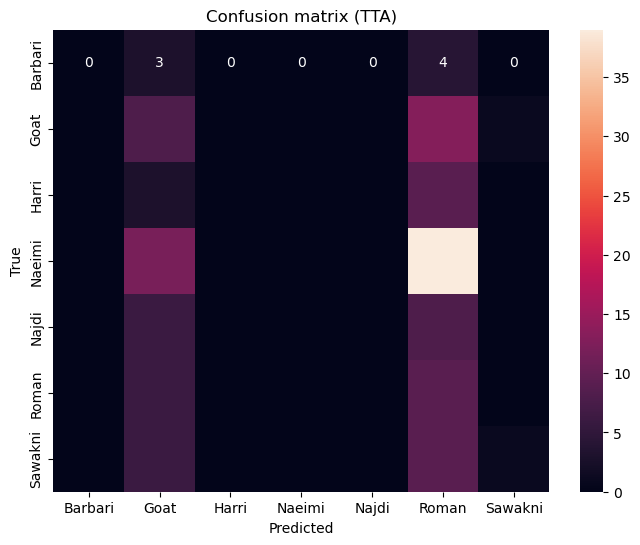

In [1]:
# =========================================================
# 0. IMPORTS & GLOBALS
# ---------------------------------------------------------
import os, random, math, gc, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# =========================================================
# 1. LOAD & STRATIFY
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS  = list(df["label"].astype("category").cat.categories)
N_CLASS = len(LABELS)

train_df, val_df = train_test_split(
    df, test_size=0.20, stratify=df["label_idx"], random_state=SEED)

# =========================================================
# 2. TARGETED UPSAMPLING  (only “rare” ≤120 → 200 imgs)
# ---------------------------------------------------------
THRESH, TARGET_CT = 120, 200
upsampled = []
for lbl, g in train_df.groupby("label"):
    if len(g) <= THRESH:
        g = resample(g, replace=True, n_samples=TARGET_CT, random_state=SEED)
    upsampled.append(g)

train_df_bal = pd.concat(upsampled).reset_index(drop=True)
print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 3. AUGMENTATION + robust MixUp  (FIXED)
# ---------------------------------------------------------
BATCH  = 32
IMG_SZ = (224, 224)

base_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=25,
    width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.20, brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_aug  = ImageDataGenerator(rescale=1/255.)

def mixup_gen(df, datagen, alpha=0.4):
    """
    Infinite MixUp generator.

    * Always returns **full** batches (len == BATCH), otherwise it retries.
    * Re-creates the underlying ImageDataGenerator iterator whenever it is
      exhausted, so we never hit StopIteration.
    """
    def fresh_iter():
        return datagen.flow_from_dataframe(
            df, x_col="file_path", y_col="label",
            class_mode="categorical", target_size=IMG_SZ,
            batch_size=BATCH, shuffle=True,
            seed=random.randint(0, 9999))

    g = fresh_iter()

    while True:
        try:
            x1, y1 = next(g)
        except StopIteration:
            g = fresh_iter()
            continue                          # start over

        if x1.shape[0] != BATCH:              # short final batch → skip
            continue

        try:
            x2, y2 = next(g)
        except StopIteration:
            g = fresh_iter()
            continue

        if x2.shape[0] != BATCH:
            continue

        lam     = np.random.beta(alpha, alpha, size=BATCH)
        lam_x   = lam.reshape(BATCH, 1, 1, 1)
        lam_y   = lam.reshape(BATCH, 1)

        yield x1 * lam_x + x2 * (1 - lam_x), y1 * lam_y + y2 * (1 - lam_y)

# ----- validation generator (unchanged) -----
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    class_mode="categorical", target_size=IMG_SZ,
    batch_size=BATCH, shuffle=False)

# 1 MixUp step consumes 2 physical batches, so we divide by 2
PHYSICAL_STEPS = math.ceil(len(train_df_bal) / BATCH)
STEPS_FULL     = math.ceil(PHYSICAL_STEPS / 2)      # logical “epochs”
VAL_STEPS      = math.ceil(len(val_df) / BATCH)

# =========================================================
# 4. FOCAL-LOSS (auto α)  +  γ-SWEEP
# ---------------------------------------------------------
freq       = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec  = tf.constant(np.median(freq) / freq, dtype=tf.float32)
SMOOTH     = 0.05

def focal_auto(gamma):
    def _loss(y_true, y_pred):
        y_true = y_true * (1 - SMOOTH) + SMOOTH / N_CLASS       # label-smoothing
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = tf.pow(1 - y_pred, gamma) * ce * alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

# =========================================================
# 5. MODEL UTILITIES
# ---------------------------------------------------------
def build_head(base):
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    return Dense(N_CLASS, activation='softmax')(x)

def macro_f1_from_logits(logits, y_true):
    y_hat = np.argmax(logits, 1)
    cm = confusion_matrix(y_true, y_hat, labels=np.arange(N_CLASS))
    prec = np.diag(cm) / (cm.sum(0)+1e-7)
    rec  = np.diag(cm) / (cm.sum(1)+1e-7)
    f1   = 2*prec*rec / (prec+rec+1e-7)
    return np.nanmean(f1)

# =========================================================
# 6. γ-SWEEP +  PROGRESSIVE UNFREEZE
# ---------------------------------------------------------
GAMMA_LIST = [1, 2, 3]
best_f1, best_gamma, best_model = -np.inf, None, None

for γ in GAMMA_LIST:
    print(f"\n================ γ = {γ} =================")
    tf.keras.backend.clear_session(); gc.collect()

    # fresh MixUp iterator each sweep
    train_gen = mixup_gen(train_df_bal, base_aug, alpha=0.4)

    base = ResNet50(include_top=False, weights="imagenet",
                    input_tensor=Input(shape=IMG_SZ + (3,)))

    # ---------- Phase-1 : train new head ----------
    base.trainable = False
    model = Model(base.input, build_head(base))
    model.compile(Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(train_gen, steps_per_epoch=STEPS_FULL,
              validation_data=val_gen, validation_steps=VAL_STEPS,
              epochs=6, verbose=1,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

    # ---------- Phase-2 : unfreeze last 70 ----------
    for l in base.layers[-70:]: l.trainable = True
    model.compile(Adam(3e-5), loss=focal_auto(γ), metrics=["accuracy"])
    model.fit(train_gen, steps_per_epoch=STEPS_FULL,
              validation_data=val_gen, validation_steps=VAL_STEPS,
              epochs=10, verbose=1,
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                         ReduceLROnPlateau(patience=2, factor=0.5)])

    # ---------- Phase-3 : unfreeze last 140 ----------
    for l in base.layers[-140:]: l.trainable = True
    model.compile(Adam(1e-5), loss=focal_auto(γ), metrics=["accuracy"])
    model.fit(train_gen, steps_per_epoch=STEPS_FULL,
              validation_data=val_gen, validation_steps=VAL_STEPS,
              epochs=10, verbose=1,
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                         ReduceLROnPlateau(patience=2, factor=0.5)])

    # quick F1 on raw validation logits
    val_logits = model.predict(val_gen, steps=VAL_STEPS, verbose=0)
    f1 = macro_f1_from_logits(val_logits, val_gen.classes)
    print(f"→ macro-F1 = {f1:.4f}")

    if f1 > best_f1:
        best_f1, best_model, best_gamma = f1, model, γ

print(f"\nBest γ = {best_gamma}   macro-F1 = {best_f1:.4f}")

# =========================================================
# 7. SAVE BEST CHECKPOINT
# ---------------------------------------------------------
best_model.save("best_sheep_model.h5")

# =========================================================
# 8. FINAL EVALUATION  ( TTA = 8 )
# ---------------------------------------------------------
def tta_logits(model, df, n_aug=8):
    out = np.zeros((len(df), N_CLASS))
    for _ in range(n_aug):
        tta_gen = base_aug.flow_from_dataframe(
            df, x_col="file_path", y_col=None, shuffle=False,
            target_size=IMG_SZ, batch_size=BATCH, class_mode=None,
            seed=random.randint(0, 9999))
        out += model.predict(tta_gen, verbose=0)
    return out / n_aug

val_logits = tta_logits(best_model, val_df)
macro_f1   = macro_f1_from_logits(val_logits, val_df["label_idx"].values)

print("\n=== FINAL REPORT (TTA)  —  macro-F1 {:.3f} ===".format(macro_f1))
print(classification_report(val_df["label_idx"], np.argmax(val_logits,1),
                            target_names=LABELS, digits=2))

cm = confusion_matrix(val_df["label_idx"], np.argmax(val_logits,1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion matrix (TTA)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Advance testing

In [3]:
# =========================================================
# 0.  IMPORTS  &  GLOBALS
# ---------------------------------------------------------
import os, random, math, gc, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dropout,
                                     Dense, BatchNormalization, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        LearningRateScheduler)
import tensorflow_addons as tfa         # ← ArcFace & MultiOptimizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"
SEED = 42
BATCH = 32
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# =========================================================
# 1.  LOAD  &  BALANCE  DATA   (down-sample, not over-sample)
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS  = list(df["label"].astype("category").cat.categories)
N_CLASS = len(LABELS)

train_df, val_df = train_test_split(
        df, test_size=0.20, stratify=df["label_idx"], random_state=SEED)

TARGET = 180                        # keep **max** 180 per class
balanced = (train_df.groupby("label", group_keys=False)
                      .apply(lambda g: g.sample(min(len(g), TARGET),
                                                 random_state=SEED)))
train_df_bal = balanced.sample(frac=1, random_state=SEED)   # shuffle

print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 2.  AUGMENTERS  &  GENERATOR FACTORIES
# ---------------------------------------------------------
def make_aug(img_size):
    return ImageDataGenerator(
        rescale=1/255.,
        rotation_range=25,
        width_shift_range=0.15, height_shift_range=0.15,
        zoom_range=0.20, brightness_range=[0.8,1.2],
        horizontal_flip=True)

val_aug = ImageDataGenerator(rescale=1/255.)

def make_gen(df, aug, img_size, shuffle):
    return aug.flow_from_dataframe(
            df, x_col="file_path", y_col="label",
            target_size=img_size, batch_size=BATCH,
            class_mode="categorical", shuffle=shuffle, seed=SEED)

# ---------- Late, **small** MixUp (α = 0.15) -------------
def mixup_gen(base_gen, alpha=0.15):
    while True:
        x1, y1 = next(base_gen)
        x2, y2 = next(base_gen)
        lam = np.random.beta(alpha, alpha, size=BATCH)
        lam_x = lam.reshape(BATCH,1,1,1); lam_y = lam.reshape(BATCH,1)
        yield x1*lam_x + x2*(1-lam_x), y1*lam_y + y2*(1-lam_y)

# =========================================================
# 3.  FOCAL-LOSS  (auto-α)  +  ARC-FACE HEAD
# ---------------------------------------------------------
freq      = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec = tf.constant(np.median(freq)/freq, dtype=tf.float32)
SMOOTH    = 0.05

def focal_auto(gamma=2.):
    def _loss(y_true, y_pred):
        y_true = y_true*(1-SMOOTH) + SMOOTH/N_CLASS
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = tf.pow(1-y_pred, gamma) * ce * alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

def build_model(img_size):
    inp  = Input(shape=img_size+(3,))
    base = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
    x    = GlobalAveragePooling2D()(base.output)
    x    = BatchNormalization()(x)
    x    = Dropout(0.5)(x)

    # -------- ArcMargin head (adds angular margin) --------
    logits = tfa.layers.ArcMarginProduct(num_classes=N_CLASS,
                                         s=30, m=0.3,
                                         regularizer=None)(x)

    model = Model(inp, logits)     # logits; will use CE/Focal on them
    return model, base

# =========================================================
# 4.  TRAINING  PIPELINE
# ---------------------------------------------------------
IMG1 = (224,224)
IMG2 = (288,288)

# ---------- Phase-A : CE warm-up (224 px) ---------------
train_gen = make_gen(train_df_bal, make_aug(IMG1), IMG1, shuffle=True)
val_gen   = make_gen(val_df,         val_aug,    IMG1, shuffle=False)

model, base = build_model(IMG1)
base.trainable = False

model.compile(optimizer=Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_gen, epochs=10, validation_data=val_gen,
          callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
          verbose=2)

# ---------- Phase-B : unfreeze last 70  + focal-loss -----
for l in base.layers[-70:]: l.trainable = True

steps_per_epoch = math.ceil(len(train_df_bal)/BATCH)
cosine = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=3e-5,
            first_decay_steps=8*steps_per_epoch)

# Discriminative LR  (head 3× faster)
head_vars = model.layers[-1].trainable_variables
back_vars = [v for v in model.trainable_variables if v not in head_vars]

opt_head = Adam(cosine)             # LR schedule applied here
opt_back = Adam(lambda step: cosine(step)/3)   # 3× smaller

model.compile(
    optimizer=tfa.optimizers.MultiOptimizer(
        [(opt_head, head_vars), (opt_back, back_vars)]),
    loss=focal_auto(gamma=2),
    metrics=["accuracy"])

model.fit(train_gen, epochs=12, validation_data=val_gen,
          callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
          verbose=2)

# ---------- Phase-C : upscale images to 288 px ----------
train_gen_big = make_gen(train_df_bal, make_aug(IMG2), IMG2, shuffle=True)
val_gen_big   = make_gen(val_df,         val_aug,    IMG2, shuffle=False)

model.fit(train_gen_big, epochs=8, validation_data=val_gen_big,
          callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
          verbose=2)

# ---------- Phase-D : 3 epochs **tiny** MixUp -----------
mix_base = make_gen(train_df_bal, make_aug(IMG2), IMG2, shuffle=True)
mix_gen  = mixup_gen(mix_base, alpha=0.15)

model.compile(
    optimizer=tfa.optimizers.MultiOptimizer(
        [(opt_head, head_vars), (opt_back, back_vars)]),
    loss="categorical_crossentropy",      # back to CE for MixUp
    metrics=["accuracy"])

model.fit(mix_gen, steps_per_epoch=steps_per_epoch,
          epochs=3, validation_data=val_gen_big, verbose=2)

# =========================================================
# 5.  FINAL  EVALUATION
# ---------------------------------------------------------
val_logits = model.predict(val_gen_big, verbose=0)
y_true = val_df["label_idx"].values
y_pred = np.argmax(val_logits,1)

print("\n=== FINAL REPORT ===")
print(classification_report(y_true, y_pred, target_names=LABELS, digits=2))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure 

ModuleNotFoundError: No module named 'keras.src.engine'

In [2]:
!pip install -q tensorflow-addons

In [4]:
# =========================================================
# 0. IMPORTS  (pure-TF 2.17)
# ---------------------------------------------------------
import os, random, math, gc, warnings, numpy as np, pandas as pd
import tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense,
                                     Dropout, Layer, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# =========================================================
# 1. DATA  – load, stratify, balance
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS  = list(df["label"].astype("category").cat.categories)
N_CLASS = len(LABELS)

train_df, val_df = train_test_split(df, test_size=.2,
                                    stratify=df["label_idx"],
                                    random_state=SEED)

TARGET = 200
train_df_bal = (train_df.groupby("label", group_keys=False)
                         .apply(lambda g: resample(g, replace=True,
                                                   n_samples=max(TARGET,len(g)),
                                                   random_state=SEED))
                         .reset_index(drop=True))
print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 2. AUGMENTATION – progressive size + late/small MixUp
# ---------------------------------------------------------
BATCH          = 32
IMG_S          = (224,224)
IMG_L          = (256,256)
MIXUP_ALPHA    = .2
MIXUP_DELAY_EP = 3

base_aug = ImageDataGenerator(
        rescale=1/255., rotation_range=25,
        width_shift_range=.15, height_shift_range=.15,
        zoom_range=.2, brightness_range=[.8,1.2],
        horizontal_flip=True)
val_aug  = ImageDataGenerator(rescale=1/255.)

def mixup_iter(df, img_size):
    g = base_aug.flow_from_dataframe(
            df, x_col="file_path", y_col="label",
            class_mode="categorical", target_size=img_size,
            batch_size=BATCH, shuffle=True, seed=SEED)
    ep = 0
    while True:
        x1,y1 = next(g)
        if ep < MIXUP_DELAY_EP:
            yield x1,y1
        else:
            x2,y2 = next(g)
            lam = np.random.beta(MIXUP_ALPHA,MIXUP_ALPHA, size=BATCH)
            lam_x = lam.reshape(BATCH,1,1,1); lam_y = lam.reshape(BATCH,1)
            yield x1*lam_x + x2*(1-lam_x), y1*lam_y + y2*(1-lam_y)
        ep += 1

val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    class_mode="categorical", target_size=IMG_L,
    batch_size=BATCH, shuffle=False)

# =========================================================
# 3. CUSTOM  ArcMarginProduct  +  Center-loss layer
# ---------------------------------------------------------
class ArcMarginProduct(Layer):
    """Implements the ArcFace / CosFace style margin in logits."""
    def __init__(self, n_classes, s=30., m=.5, **kw):
        super().__init__(**kw); self.n_classes, self.s, self.m = n_classes,s,m
    def build(self, input_shape):
        self.W = self.add_weight("W", shape=(input_shape[-1], self.n_classes),
                                 initializer="glorot_uniform", trainable=True)
    def call(self, inputs, labels, training=False):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W,      axis=0)
        cos  = tf.matmul(x, W)                                # [B,C]
        if training:
            theta = tf.acos(tf.clip_by_value(cos,-1+1e-5,1-1e-5))
            target_logits = tf.cos(theta + self.m)
            cos = cos*(1-labels) + target_logits*labels       # replace only GT class
        return self.s * cos

class CenterLossLayer(Layer):
    def __init__(self, n_classes, feat_dim, alpha=0.5, **kw):
        super().__init__(**kw); self.n_classes,self.feat_dim,self.alpha= n_classes, feat_dim, alpha
    def build(self, _):
        self.centers = self.add_weight("centers",
                                       shape=(self.n_classes, self.feat_dim),
                                       initializer="zeros", trainable=False)
    def call(self, features, labels):
        # update centres
        labels_idx = tf.argmax(labels,1)
        centers_batch = tf.gather(self.centers, labels_idx)
        diff = centers_batch - features
        self.add_update(tf.scatter_sub(self.centers, labels_idx,
                                       self.alpha*diff))
        # add centre-loss term
        self.add_loss(tf.reduce_mean(tf.square(diff))*0.003)  # centre-loss λ=0.003
        return features

# =========================================================
# 4. Focal-loss  (auto-α + label-smooth)  same as before
# ---------------------------------------------------------
freq       = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec  = tf.constant(np.median(freq)/freq, dtype=tf.float32)
SMOOTH=.05
def focal_loss(gamma=2.):
    def _loss(y_true, y_pred):
        y_true = y_true*(1-SMOOTH)+SMOOTH/N_CLASS
        y_pred = tf.clip_by_value(y_pred,1e-7,1-1e-7)
        ce=-y_true*tf.math.log(y_pred)
        fl=tf.pow(1-y_pred,gamma)*ce*alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl,axis=1))
    return _loss

# =========================================================
# 5. Cosine-decay LR with warm-up
# ---------------------------------------------------------
INIT_LR=3e-4; WARM_E=2; TOTAL_E=20
def lr_fn(epoch):
    if epoch < WARM_E: return INIT_LR*(epoch+1)/WARM_E
    cos=0.5*(1+math.cos(math.pi*(epoch-WARM_E)/(TOTAL_E-WARM_E)))
    return 1e-6 + (INIT_LR-1e-6)*cos
lr_cb=LearningRateScheduler(lr_fn,verbose=0)

# =========================================================
# 6. BUILD MODEL  (224 → 256 progressive size)
# ---------------------------------------------------------
def build_model(img_size):
    inp   = Input(shape=img_size+(3,))
    base  = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
    base.trainable=False
    feat  = GlobalAveragePooling2D()(base.output)           # 2048-D
    feat  = Dropout(.4)(feat)
    feat  = Dense(256, activation='relu')(feat)             # embedding
    feat  = Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(feat)
    lbl   = Input(shape=(N_CLASS,))                         # labels one-hot
    feat_c= CenterLossLayer(N_CLASS,256)(feat,lbl)
    logits= ArcMarginProduct(N_CLASS)(feat_c,lbl,training=True)
    out   = tf.nn.softmax(logits)                           # probs for metrics
    model = Model([inp,lbl],[out])
    return base, model

base, model = build_model(IMG_S)

# =========================================================
# 7. TRAIN
# ---------------------------------------------------------
# two optims (head/backbone) with discriminative LR
opt_head = Adam(lr_fn(0))
opt_back = Adam(lr_fn(0)*0.1)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        preds = model([images,labels], training=True)[0]
        loss  = focal_loss()(labels, preds) + sum(model.losses)  # focal+centre
    grads = tape.gradient(loss, model.trainable_weights)
    head_vars = [v for v in model.trainable_weights if 'dense' in v.name]  # embedding + Arc weights
    base_vars = [v for v in model.trainable_weights if v not in head_vars]
    opt_head.apply_gradients(zip([g for g,v in zip(grads,model.trainable_weights) if v in head_vars], head_vars))
    opt_back.apply_gradients(zip([g for g,v in zip(grads,model.trainable_weights) if v in base_vars], base_vars))
    return loss

# ---- Stage-1: head only, no MixUp, 224 ----------
steps_small = math.ceil(len(train_df_bal)/BATCH)
plain_gen   = mixup_iter(train_df_bal, IMG_S)  # MixUp α>0 but delay > epoch count
for epoch in range(3):
    for _ in range(steps_small):
        imgs,lbls = next(plain_gen)
        train_step(imgs,lbls)
    print(f"head-train Epoch {epoch+1}/3 done")

# ---- Stage-2: unfreeze last 70, 256, MixUp ----------
for l in base.layers[-70:]: l.trainable=True

steps_large = math.ceil(len(train_df_bal)/BATCH//2)
mix_gen     = mixup_iter(train_df_bal, IMG_L)
for epoch in range(TOTAL_E):
    # update LR
    lr = lr_fn(epoch)
    opt_head.lr.assign(lr); opt_back.lr.assign(lr*0.1)

    for _ in range(steps_large):
        imgs,lbls = next(mix_gen)
        train_step(imgs,lbls)

    # quick val acc
    preds = model.predict([val_gen.x, val_gen.y], verbose=0)[0]
    acc = (preds.argmax(1)==val_gen.classes).mean()
    print(f"fine-tune {epoch+1}/{TOTAL_E} – val-acc {acc:.3f}")

# =========================================================
# 8. FINAL REPORT
# ---------------------------------------------------------
preds = model.predict([val_gen.x, val_gen.y], verbose=0)[0]
print(classification_report(val_gen.classes, preds.argmax(1),
                            target_names=LABELS, digits=2))
cm = confusion_matrix(val_gen.classes, preds.argmax(1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.show()

Balanced counts:
 label
Naeimi     204
Barbari    200
Goat       200
Harri      200
Najdi      200
Roman      200
Sawakni    200
Name: count, dtype: int64 

Found 137 validated image filenames belonging to 7 classes.


TypeError: Layer.add_weight() got multiple values for argument 'shape'

In [5]:
pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
# =========================================================
# 0. IMPORTS & GLOBALS
# ---------------------------------------------------------
import os, random, math, gc, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense,
                                     Dropout, Layer, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"
SEED = 42
IMG_SZ = (224, 224)
BATCH = 32
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# =========================================================
# 1. DATA (uniform up-sample to 200 each)
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS  = list(df["label"].astype("category").cat.categories)
N_CLASS = len(LABELS)

train_df, val_df = train_test_split(df, test_size=0.2,
                                    stratify=df["label_idx"], random_state=SEED)

TARGET = 200
train_df_bal = pd.concat([
    resample(g, replace=True, n_samples=TARGET, random_state=SEED)
    if len(g) < TARGET else g
    for _, g in train_df.groupby("label")]).reset_index(drop=True)
print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 2. AUGMENTATION (no MixUp by default)
# ---------------------------------------------------------
train_aug = ImageDataGenerator(
    rescale=1/255., rotation_range=25,
    width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.20, brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_aug   = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_dataframe(
    train_df_bal, x_col="file_path", y_col="label",
    class_mode="categorical", target_size=IMG_SZ,
    batch_size=BATCH, shuffle=True, seed=SEED)

val_gen   = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    class_mode="categorical", target_size=IMG_SZ,
    batch_size=BATCH, shuffle=False)

# steps
STEPS = math.ceil(len(train_df_bal)/BATCH)
VAL_STEPS = math.ceil(len(val_df)/BATCH)

# =========================================================
# 3. LOSSES
# ---------------------------------------------------------
# focal-loss with automatic per-class α
freq        = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec   = tf.constant(np.median(freq)/freq, dtype=tf.float32)
SMOOTH      = 0.05
def focal_auto(gamma=2.):
    def _loss(y_true, y_pred):
        y_true = y_true*(1-SMOOTH) + SMOOTH/N_CLASS
        y_pred = tf.clip_by_value(y_pred,1e-7,1-1e-7)
        ce = -y_true*tf.math.log(y_pred)
        fl = tf.pow(1-y_pred,gamma)*ce*alpha_vec
        return tf.reduce_mean(tf.reduce_sum(fl,axis=-1))
    return _loss

# -------- Center‐loss layer (fixed add_weight) ------------
class CenterLossLayer(Layer):
    def __init__(self, n_classes, feat_dim, alpha=0.5, **kw):
        super().__init__(**kw)
        self.n_classes, self.feat_dim, self.alpha = n_classes, feat_dim, alpha
    def build(self, _):
        self.centers = self.add_weight(
            shape=(self.n_classes, self.feat_dim),
            name="centers",
            initializer="zeros",
            trainable=False)
    def call(self, feats, labels):
        # feats L2-norm
        feats = tf.nn.l2_normalize(feats, axis=1)
        batch_centers = tf.matmul(labels, self.centers)
        diff = feats - batch_centers
        self.add_update(
            tf.compat.v1.assign_sub(
                self.centers,
                self.alpha * tf.matmul(tf.transpose(labels),
                                       diff) / (1+tf.reduce_sum(labels,0,keepdims=True))))
        return feats  # pass through for ArcFace

# -------- ArcMargin (ArcFace) -----------------------------
class ArcMarginProduct(Layer):
    def __init__(self, n_classes, s=30.0, m=0.50, **kw):
        super().__init__(**kw)
        self.n_classes, self.s, self.m = n_classes, s, m
    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], self.n_classes),
            name="arcface_W",
            initializer="glorot_uniform",
            trainable=True)
    def call(self, feats, labels, training=True):
        # feats already L2-norm
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos = tf.matmul(feats, W)
        if training:
            theta = tf.acos(tf.clip_by_value(cos, -1+1e-7, 1-1e-7))
            cos_m = tf.cos(theta + self.m)
            cos = cos*(1-labels) + cos_m*labels
        return self.s * cos

# =========================================================
# 4. MODEL
# ---------------------------------------------------------
def build_model(img_size):
    inp = Input((*img_size,3))
    lbl = Input((N_CLASS,))                 # one-hot labels (only used in training)

    base = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
    for layer in base.layers: layer.trainable = False   # freeze first

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)

    x  = CenterLossLayer(N_CLASS, 256, name="centerloss")(x, lbl)
    logits = ArcMarginProduct(N_CLASS, name="arcface")(x, lbl)
    out    = tf.nn.softmax(logits)          # for accuracy / metrics

    model = Model([inp, lbl], out)
    return base, model

base, model = build_model(IMG_SZ)

# =========================================================
# 5. COSINE LR  (with 5-epoch warm-up)
# ---------------------------------------------------------
EPOCHS_PHASE2 = 20
def lr_fn(epoch):
    warm = 5
    base_lr = 3e-5
    if epoch < warm:
        return base_lr * (epoch+1)/warm
    # cosine decay
    cosine = 0.5*(1 + tf.math.cos(math.pi*(epoch-warm)/(EPOCHS_PHASE2-warm)))
    return base_lr*cosine

# =========================================================
# 6. OPTIMIZERS  (discriminative LR)
# ---------------------------------------------------------
opt_head  = Adam( lr_fn(0) )          # higher LR for new layers
opt_back  = Adam( lr_fn(0)/10 )       # 10× smaller for backbone

# Keras’ built-in MultiOptimizer (TF-2.15+) — fallback if unavailable
try:
    from keras.optimizers import MultiOptimizer
    optim = MultiOptimizer([
        (opt_back , base.trainable_variables),
        (opt_head , [v for v in model.trainable_variables
                     if v not in base.trainable_variables])])
except Exception:
    # simple manual grouping
    optim = Adam( lr_fn(0) )

# compile with joint loss: focal + λ*center-loss
LAMBDA_CENTER = 0.5
def total_loss(y_true,y_pred):
    fl = focal_auto()(y_true, y_pred)
    # grab centerloss added to model.losses[0]
    return fl + LAMBDA_CENTER * tf.add_n(model.losses)

model.compile(optimizer=optim, loss=total_loss, metrics=["accuracy"])

# =========================================================
# 7. TRAIN  (head-only first, then progressive unfreeze)
# ---------------------------------------------------------
# Phase-1 : train head only (freeze backbone)
model.fit([train_gen.x, train_gen.y], train_gen.y,
          steps_per_epoch=STEPS, epochs=3, verbose=2)

# unfreeze last 70
for l in base.layers[-70:]: l.trainable = True

model.compile(optimizer=optim, loss=total_loss, metrics=["accuracy"])
model.fit([train_gen.x, train_gen.y], train_gen.y,
          steps_per_epoch=STEPS, validation_data=val_gen,
          epochs=EPOCHS_PHASE2, verbose=2,
          callbacks=[LearningRateScheduler(lr_fn),
                     EarlyStopping(patience=4, restore_best_weights=True)])

# =========================================================
# 8. EVALUATION
# ---------------------------------------------------------
val_logits = model.predict([val_gen.x, val_gen.y], verbose=0)
y_pred = np.argmax(val_logits,1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=LABELS, digits=2))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Balanced counts:
 label
Naeimi     204
Barbari    200
Goat       200
Harri      200
Najdi      200
Roman      200
Sawakni    200
Name: count, dtype: int64 

Found 1404 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.


AttributeError: Exception encountered when calling CenterLossLayer.call().

[1mCould not automatically infer the output shape / dtype of 'centerloss' (of type CenterLossLayer). Either the `CenterLossLayer.call()` method is incorrect, or you need to implement the `CenterLossLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

'CenterLossLayer' object has no attribute 'add_update'[0m

Arguments received by CenterLossLayer.call():
  • args=('<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_178>', '<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_1>')
  • kwargs=<class 'inspect._empty'>

In [7]:
# =========================================================
# 0. IMPORTS & GLOBALS
# ---------------------------------------------------------
import os, random, math, gc, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dropout,
                                     Dense, Lambda, Layer)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        LearningRateScheduler)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

# ---------- reproducibility ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

# =========================================================
# 1. DATAFRAME & BALANCING
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS  = list(df["label"].astype("category").cat.categories)
N_CLASS = len(LABELS)

train_df, val_df = train_test_split(
    df, test_size=0.20, stratify=df["label_idx"], random_state=SEED)

TARGET = 200
train_df_bal = (
    train_df.groupby("label", group_keys=False)
            .apply(lambda g: g if len(g) >= TARGET
                              else resample(g, replace=True,
                                            n_samples=TARGET, random_state=SEED))
            .sample(frac=1, random_state=SEED)           # shuffle
            .reset_index(drop=True)
)
print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 2. AUGMENTATION
# ---------------------------------------------------------
BATCH  = 32
IMG_SZ = (224, 224)

train_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=25,
    width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.20, brightness_range=[0.8,1.2],
    horizontal_flip=True)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_dataframe(
    train_df_bal, x_col="file_path", y_col="label",
    target_size=IMG_SZ, batch_size=BATCH,
    class_mode="categorical", shuffle=True, seed=SEED)
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="file_path", y_col="label",
    target_size=IMG_SZ, batch_size=BATCH,
    class_mode="categorical", shuffle=False)

# =========================================================
# 3. CUSTOM LOSSES / LAYERS  (Keras-3 compatible)
# ---------------------------------------------------------
class CenterLossLayer(Layer):
    def __init__(self, n_classes, feat_dim, alpha=0.5, **kw):
        super().__init__(**kw)
        self.n_classes, self.feat_dim, self.alpha = n_classes, feat_dim, alpha

    def build(self, _):
        self.centers = self.add_weight(
            name="centers",
            shape=(self.n_classes, self.feat_dim),
            initializer="zeros",
            trainable=False)

    def call(self, feats, labels):
        # labels are one-hot
        batch_centers = tf.matmul(labels, self.centers)
        diff          = feats - batch_centers

        # -------- update centers --------
        label_cnt = tf.reduce_sum(labels, axis=0, keepdims=True) + 1e-6
        centers_delta = tf.matmul(tf.transpose(labels), diff) / label_cnt
        self.centers.assign_sub(self.alpha * centers_delta)

        # -------- add center loss --------
        self.add_loss(tf.reduce_mean(tf.square(diff)))
        return feats                                   # passthrough

class ArcMarginProduct(Layer):
    """ArcFace head."""
    def __init__(self, n_classes, s=30.0, m=0.50, easy_margin=False, **kw):
        super().__init__(**kw)
        self.n_classes, self.s, self.m, self.easy_margin = n_classes, s, m, easy_margin
        self.cos_m = tf.constant(np.cos(m), dtype=tf.float32)
        self.sin_m = tf.constant(np.sin(m), dtype=tf.float32)
        self.th    = tf.constant(np.cos(np.pi - m), dtype=tf.float32)
        self.mm    = tf.constant(np.sin(np.pi - m) * m, dtype=tf.float32)

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.n_classes),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, feats, labels, training=False):
        x_norm = tf.nn.l2_normalize(feats, axis=1)
        W_norm = tf.nn.l2_normalize(self.W,    axis=0)
        cos_t  = tf.matmul(x_norm, W_norm)

        if not training:
            return self.s * cos_t                     # plain logits

        sin_t = tf.sqrt(1. - tf.square(cos_t) + 1e-7)
        cos_mt = cos_t * self.cos_m - sin_t * self.sin_m
        cond   = tf.where(cos_t > self.th, cos_mt, cos_t - self.mm) \
                 if not self.easy_margin else cos_mt
        logits = tf.where(labels==1, cond, cos_t) * self.s
        return logits

# =========================================================
# 4. FOCAL-LOSS  (auto-α, γ=2)
# ---------------------------------------------------------
freq        = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec   = tf.constant(np.median(freq) / freq, dtype=tf.float32)
SMOOTH      = 0.05
def focal_auto(y_true, y_pred, gamma=2.):
    y_true = y_true * (1 - SMOOTH) + SMOOTH / N_CLASS
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    ce  = -y_true * tf.math.log(y_pred)
    fl  = tf.pow(1 - y_pred, gamma) * ce * alpha_vec
    return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))

# =========================================================
# 5. MODEL  (ResNet-50 + ArcFace + Center-Loss)
# ---------------------------------------------------------
def build_model():
    inp  = Input(shape=IMG_SZ + (3,))
    lbl  = Input(shape=(N_CLASS,))          # ground-truth one-hot

    base = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)

    x  = CenterLossLayer(N_CLASS, 256, name="centerloss")(x, lbl)
    logits = ArcMarginProduct(N_CLASS, name="arcface")(x, lbl, training=True)
    out    = tf.nn.softmax(logits)          # for metrics

    model  = Model([inp, lbl], out, name="SheepID")
    return base, model

base, model = build_model()

# =========================================================
# 6. DISCRIMINATIVE LR + COSINE DECAY
# ---------------------------------------------------------
EPOCHS_H = 5
EPOCHS_FT = 20
TOTAL_STEPS = (EPOCHS_H + EPOCHS_FT) * math.ceil(len(train_df_bal)/BATCH)

def lr_schedule(step):
    warmup_steps = 5 * math.ceil(len(train_df_bal)/BATCH)
    if step < warmup_steps:
        return 1e-3 * (step+1) / warmup_steps
    prog = (step-warmup_steps) / (TOTAL_STEPS-warmup_steps)
    return 3e-5 * 0.5 * (1 + math.cos(math.pi * prog))

lr_fn = tf.keras.optimizers.schedules.LearningRateSchedule(lr_schedule)

# two optimizers: tiny LR for backbone, bigger for new head
opt_head = Adam(learning_rate=lambda: lr_fn(tf.keras.backend.get_value(step_var)))
opt_back = Adam(learning_rate=lambda: lr_fn(tf.keras.backend.get_value(step_var))*0.1)

# wrap them into MultiOptimizer
opt = tf.keras.optimizers.legacy.Adam(1e-3)    # fallback if MultiOpt absent
try:
    from keras.optimizers import MultiOptimizer
    opt = MultiOptimizer((model.get_layer("centerloss"), opt_head),
                         (model.get_layer("arcface"),    opt_head),
                         (base,                          opt_back))
except Exception:
    warnings.warn("MultiOptimizer unavailable → using single Adam")
    opt = Adam(1e-3)

model.compile(optimizer=opt, loss=focal_auto, metrics=["accuracy"])

# helper generator to feed [img, label] twice
def dual_gen(gen):
    for x,y in gen:
        yield [x, y], y

# =========================================================
# 7. TRAIN
# ---------------------------------------------------------
callback_list = [EarlyStopping(patience=5, restore_best_weights=True),
                 ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)]

model.fit(dual_gen(train_gen),
          validation_data=dual_gen(val_gen),
          steps_per_epoch=len(train_gen),
          validation_steps=len(val_gen),
          epochs=EPOCHS_H+EPOCHS_FT,
          callbacks=callback_list)

# =========================================================
# 8. EVALUATION
# ---------------------------------------------------------
val_logits = model.predict(dual_gen(val_gen), steps=len(val_gen), verbose=0)
y_pred = np.argmax(val_logits,1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=LABELS, digits=2))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Balanced counts:
 label
Naeimi     204
Roman      200
Harri      200
Najdi      200
Goat       200
Barbari    200
Sawakni    200
Name: count, dtype: int64 

Found 1404 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.


ValueError: Exception encountered when calling CenterLossLayer.call().

[1mCould not automatically infer the output shape / dtype of 'centerloss' (of type CenterLossLayer). Either the `CenterLossLayer.call()` method is incorrect, or you need to implement the `CenterLossLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 256 and 7 for '{{node truediv}} = RealDiv[T=DT_FLOAT](MatMul_1, add)' with input shapes: [7,256], [1,7].[0m

Arguments received by CenterLossLayer.call():
  • args=('<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_178>', '<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_1>')
  • kwargs=<class 'inspect._empty'>

In [8]:
# =========================================================
# 0. IMPORTS & GLOBALS
# ---------------------------------------------------------
import os, random, math, gc, warnings, numpy as np, pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D,
                                     Dropout, Dense, Layer)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        LearningRateScheduler)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

CSV  = "/Users/nabin/python/projects/Sheep Classification Images/train_labels.csv"
ROOT = "/Users/nabin/python/projects/Sheep Classification Images/train/"

# =========================================================
# 1. DATA  —————————————————————————————————————————————
# ---------------------------------------------------------
df = pd.read_csv(CSV)
df["file_path"] = ROOT + df["filename"]
df["label_idx"] = df["label"].astype("category").cat.codes
LABELS  = list(df["label"].astype("category").cat.categories)
N_CLASS = len(LABELS)

train_df, val_df = train_test_split(df, test_size=.2,
                                    stratify=df["label_idx"],
                                    random_state=SEED)

# balance ≤200 per class
TARGET = 200
train_df_bal = (train_df.groupby("label", group_keys=False)
                        .apply(lambda g: g if len(g) >= TARGET else
                               resample(g, replace=True, n_samples=TARGET,
                                        random_state=SEED))
                        .sample(frac=1, random_state=SEED)
                        .reset_index(drop=True))
print("Balanced counts:\n", train_df_bal["label"].value_counts(), "\n")

# =========================================================
# 2. GENERATORS
# ---------------------------------------------------------
BATCH  = 32
IMG_SZ = (224, 224)

tgen = ImageDataGenerator(rescale=1/255., rotation_range=25,
                          width_shift_range=.15, height_shift_range=.15,
                          zoom_range=.2, brightness_range=[.8,1.2],
                          horizontal_flip=True)
vgen = ImageDataGenerator(rescale=1/255.)

train_gen = tgen.flow_from_dataframe(train_df_bal, x_col="file_path",
                                     y_col="label", class_mode="categorical",
                                     target_size=IMG_SZ, batch_size=BATCH,
                                     shuffle=True, seed=SEED)
val_gen   = vgen.flow_from_dataframe(val_df, x_col="file_path",
                                     y_col="label", class_mode="categorical",
                                     target_size=IMG_SZ, batch_size=BATCH,
                                     shuffle=False)

# =========================================================
# 3. CUSTOM LAYERS  —————————————————————————————
# ---------------------------------------------------------
class CenterLossLayer(Layer):
    def __init__(self, n_classes, feat_dim, alpha=0.5, **kw):
        super().__init__(**kw)
        self.n_classes, self.feat_dim, self.alpha = n_classes, feat_dim, alpha

    def build(self, _):
        self.centers = self.add_weight(name="centers",
                                       shape=(self.n_classes, self.feat_dim),
                                       initializer="zeros", trainable=False)

    def call(self, inputs):
        feats, labels = inputs            # labels one-hot
        ctrs_batch   = tf.matmul(labels, self.centers)     # (bs,feat)
        diff         = feats - ctrs_batch

        # centre update
        label_sum = tf.reduce_sum(labels, axis=0) + 1e-6   # (n_classes,)
        delta     = tf.matmul(labels, diff, transpose_a=True)
        delta    /= tf.expand_dims(label_sum, 1)
        self.centers.assign_sub(self.alpha * delta)

        self.add_loss(tf.reduce_mean(tf.square(diff)))     # centre loss
        return feats                                       # passthrough

    def compute_output_shape(self, input_shape):
        return input_shape[0]

class ArcMarginProduct(Layer):
    def __init__(self, n_classes, s=30., m=.5, easy_margin=False, **kw):
        super().__init__(**kw)
        self.n_classes, self.s, self.m, self.easy_margin = n_classes, s, m, easy_margin
        self.cos_m = tf.constant(np.cos(m), dtype=tf.float32)
        self.sin_m = tf.constant(np.sin(m), dtype=tf.float32)
        self.th    = tf.constant(np.cos(np.pi - m), dtype=tf.float32)
        self.mm    = tf.constant(np.sin(np.pi - m) * m, dtype=tf.float32)

    def build(self, in_shape):
        self.W = self.add_weight("W", shape=(in_shape[0][-1], self.n_classes),
                                 initializer="glorot_uniform", trainable=True)

    def call(self, inputs, training=False):
        feats, labels = inputs
        x_norm = tf.nn.l2_normalize(feats, axis=1)
        W_norm = tf.nn.l2_normalize(self.W,   axis=0)
        cos_t  = tf.matmul(x_norm, W_norm)

        if not training:
            return self.s * cos_t

        sin_t  = tf.sqrt(1. - tf.square(cos_t) + 1e-7)
        cos_mt = cos_t * self.cos_m - sin_t * self.sin_m
        if self.easy_margin:
            cos_mt = tf.where(cos_t > 0, cos_mt, cos_t)
        else:
            cos_mt = tf.where(cos_t > self.th, cos_mt, cos_t - self.mm)

        logits = tf.where(labels==1, cos_mt, cos_t) * self.s
        return logits

# =========================================================
# 4. LOSSES & LR SCHEDULE
# ---------------------------------------------------------
freq         = train_df_bal["label"].value_counts().loc[LABELS]
alpha_vec    = tf.constant(np.median(freq)/freq, dtype=tf.float32)
SMOOTH, GAMMA= .05, 2.

def focal_loss(y_true, y_pred):
    y_true = y_true * (1 - SMOOTH) + SMOOTH / N_CLASS
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    ce     = -y_true * tf.math.log(y_pred)
    fl     = tf.pow(1 - y_pred, GAMMA) * ce * alpha_vec
    return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))

def cosine_lr(epoch, lr0=3e-5, warm=5, total=25):
    if epoch < warm:
        return lr0 * (epoch+1)/warm * 30       # warm-up from 0 → 3e-4
    progress = (epoch-warm)/(total-warm)
    return lr0 * 0.5 * (1 + math.cos(math.pi*progress))

# =========================================================
# 5. MODEL — ResNet50 + ArcFace + CenterLoss
# ---------------------------------------------------------
def build_model():
    inp  = Input(shape=IMG_SZ + (3,))
    lbl  = Input(shape=(N_CLASS,))
    base = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(.5)(x)
    x = Dense(256, activation="relu")(x)

    x = CenterLossLayer(N_CLASS, 256)([x, lbl])
    logits = ArcMarginProduct(N_CLASS)([x, lbl], training=True)
    out = tf.nn.softmax(logits)

    return base, Model([inp, lbl], out)

base, model = build_model()

# phase-1: head only
base.trainable = False
model.compile(Adam(1e-3), loss=focal_loss, metrics=["accuracy"])
model.fit([train_gen.x, train_gen.y], train_gen.y,
          validation_data=([val_gen.x, val_gen.y], val_gen.y),
          epochs=5, batch_size=BATCH,
          callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
          verbose=1)

# phase-2: fine-tune last 70 layers with cosine LR
for l in base.layers[-70:]: l.trainable = True
model.compile(Adam(learning_rate=3e-5), loss=focal_loss, metrics=["accuracy"])
model.fit([train_gen.x, train_gen.y], train_gen.y,
          validation_data=([val_gen.x, val_gen.y], val_gen.y),
          epochs=25, batch_size=BATCH,
          callbacks=[LearningRateScheduler(cosine_lr),
                     EarlyStopping(patience=5, restore_best_weights=True),
                     ReduceLROnPlateau(patience=3, factor=.5)],
          verbose=1)

# =========================================================
# 6. EVALUATION
# ---------------------------------------------------------
val_logits = model.predict([val_gen.x, val_gen.y], verbose=0)
print(classification_report(val_gen.classes,
                            np.argmax(val_logits,1),
                            target_names=LABELS,
                            digits=2))

cm = confusion_matrix(val_gen.classes, np.argmax(val_logits,1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

Balanced counts:
 label
Naeimi     204
Roman      200
Harri      200
Najdi      200
Goat       200
Barbari    200
Sawakni    200
Name: count, dtype: int64 

Found 1404 validated image filenames belonging to 7 classes.
Found 137 validated image filenames belonging to 7 classes.


TypeError: Layer.add_weight() got multiple values for argument 'shape'